In [ ]:
import pickle
import numpy as np
import pandas as pd
import time

from matplotlib import pyplot as plt
from functions import get_X, get_y, question_from_v, data_without_v, get_movies_scores, remove_empty_variables
from metrics import random_forest, forward_feature_selection, backward_feature_elimination, random_variable_choice, variable_mean_choice
from variable_selection_metrics import user_questions, random_questions, loop_simulation, metrics_simulations

In [ ]:
%load_ext autoreload
%autoreload 2

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

# Load data

In [ ]:
pkl = open('experiment_clean_lastfm.pkl','rb')
experiment_df = pickle.load(pkl)
pkl.close()

In [ ]:
df = experiment_df.copy()

In [ ]:
for c in get_X(experiment_df):
    df[c][df[c] >= 1] = 1

In [ ]:
df.columns.size

# Optimization

In [ ]:
metric_list = [random_variable_choice]  #[random_forest, forward_feature_selection, random_variable_choice, variable_mean_choice]
metric_names = ["VMC"] #["RF", "FFS", "RVC", "VMC"]

loopsize = 1

In [ ]:
results, times, question_counts = metrics_simulations(df, metric_list, metric_names, loopsize, display = True)

In [ ]:
np.mean(df[73])

In [ ]:
selected_tags[selected_tags.tagID == 73]

# Creating a tree for the random forest choice

- Issue n°1 : a tree on 73 tags will have around 10^22 nodes
- Actually, the tree is not that deep -> Computation
- Pre-creating a part of the tree can be a good start : the longest computations are the first (always the same)

In term of area, only answering yes would bring to a depth of around 15 questions. Imagining the tree like a triangle would mean that the tree has a shape of 15 * 73 = 1095. Let's try it.

In [ ]:
15 * 73

In [ ]:
user_result = user_questions(df, random_forest)

Fonctions :
- Calcul d'une BDD après application d'une variable (data_without_v)
- Calcul d'une BDD après application d'une séquence de variables
- Application d'une séquence de question à une BDD, True si termine False sinon.

In [ ]:
from functions import data_without_v

In [ ]:
def data_without_sequence(data, sequence):
    """ By default, the threshold of variables are their mean on the initial database """
    new_data = data.copy()
    for (v, b) in sequence:
        X = get_X(new_data)
        avg = np.mean(X[v])
        new_data = data_without_v(new_data, v, avg, lower=(not b))
    return new_data

In [ ]:
l = [(73, True), (79, True)]

In [ ]:
data_without_sequence(df, l).shape

In [ ]:
def ask_question_sequence(data, sequence):
    new_data = data_without_sequence(data, sequence)
    return new_data.item.unique().size <= 10

In [ ]:
l = [(356, True), (275, True)]

In [ ]:
ask_question_sequence(df, l)

In [ ]:
df.columns.size

In [ ]:
import copy

In [ ]:
class Tree:
    def __init__(self, v):
        self.v = v
        self.left = None
        self.right = None
    
    def set_left(self, t):
        self.left = t

    def set_right(self, l):
        self.right = l
    
    def copy(self):
        if self.v == -1:
            return Tree(-1)
        else:
            t = Tree(self.v)
            if self.left != None:
                t.set_left(self.left.copy())
            if self.right != None:
                t.set_right(self.right.copy())
            return t

- Fonction supérieure ( BDD, metric )
- Sequence = []
- Fonction récursive ( sequence ) :
    - BDD_ = compute_sequence
    - if que_sequ(BDD_) ne donne pas de solution :
        - v = metric(BDD_)
        - sequence1 = sequence + [v:T]
        - sequence2 = sequence + [v:F]
        - Tree = Tree(v)
        - Tree.left = aux(sequence1)
        - Tree.right = aux(sequence2)
        - Return tree

In [ ]:
def pre_compute_tree(data, metric, depth = 5):
    def rec(s):
        new_data = data_without_sequence(data, s)
        if len(s) > depth:
            return Tree(-1)
        if new_data.item.unique().size > 10 and len(get_X(new_data).columns) > 1:
            X, y = get_X(new_data), get_y(new_data)
            v = metric(X, y, display=False)
            
            s1 = s + [(v, True)]
            s2 = s + [(v, False)]
            print(s)
            
            t = Tree(v)
            t.set_left(rec(s1))
            t.set_left(rec(s2))
            
            return t
        return Tree(-1)
    return rec([])

In [ ]:
t0 = time.time()
t5 = pre_compute_tree(df, random_forest, depth = 5)
time_t5 = time.time() - t0

# C'est quand même un peu long

-> Pré-créer la base de l'arbre (les premiers noeuds) puis laisse faire le reste par les algos.

In [ ]:
t.v

- Faire une fonction qui calcul à partir d'un arbre
- Faire tourner des rf dessus avec des arbres de prof différentes
- Calculer les temps de calculs des arbres en fonction de leurs profondeurs
- Faire les calculs d'efficacité et de spread pour des bases plus grandes

In [ ]:
def random_questions(data, metric, display = False, tree = None):
    new_data = data.copy()
    question_count = 0
    t = Tree(-1)
    if tree != None:
        t = tree.copy()
    
    while new_data.item.unique().size > 10 and len(get_X(new_data).columns) > 1:
        
        
        X, y = get_X(new_data), get_y(new_data)
        if t != None and t.v != -1:
            v = t.v
        else:
            v = metric(X, y, display=display)
        
        avg = np.mean(X[v])
        
        lower = True
        middle = (avg) / (0.0001 + np.max(new_data[v]) - np.min(new_data[v]))
        if np.random.rand() < middle:
            lower = False
        new_data = data_without_v(new_data, v, avg, lower=lower)
        if t != None and t.v != -1:
            if lower:
                t = t.left
            else:
                t = t.right
        
        if display:
            print(v)
            print(avg)
            print(lower)
            print(new_data.item.unique().size)
        
        question_count += 1
        
    return new_data, question_count

In [ ]:
random_questions(df, random_forest, display = False, tree = t5)

In [ ]:
tree5_times = []
for k in range(50):
    t0 = time.time()
    random_questions(df, random_forest, display = False, tree = t5)
    tree5_times.append(time.time() - t0)
    print(k)

In [ ]:
notree_times = []
for k in range(20):
    t0 = time.time()
    random_questions(df, random_forest, display = False)
    notree_times.append(time.time() - t0)
    print(k)

In [ ]:
t0 = time.time()
t10 = pre_compute_tree(df, random_forest, depth = 10)
time_t10 = time.time() - t0

In [ ]:
tree10_times = []
for k in range(50):
    t0 = time.time()
    random_questions(df, random_forest, display = False, tree = t10)
    tree10_times.append(time.time() - t0)
    print(k)

In [ ]:
print(np.mean(notree_times))
print(np.mean(tree5_times))
print(np.mean(tree10_times))

In [ ]:
plt.bar(["No tree", "Depth 5 tree", "Depth 10 tree"], [np.mean(notree_times), np.mean(tree5_times), np.mean(tree10_times)], color = ['b','g','r','y'])

plt.show()

In [ ]:
t0 = time.time()
t15 = pre_compute_tree(df, random_forest, depth = 15)
time_t15 = time.time() - t0

In [ ]:
tree15_times = []
for k in range(50):
    t0 = time.time()
    random_questions(df, random_forest, display = False, tree = t15)
    tree15_times.append(time.time() - t0)
    print(k)

In [ ]:
plt.bar(["No tree", "Depth 5 tree", "Depth 10 tree", "Depth 15 tree"], [np.mean(notree_times), np.mean(tree5_times), np.mean(tree10_times), np.mean(tree15_times)], color = ['b','g','r','y'])
plt.title("Average question sequence time with RF for a 226 tags database")
plt.show()

In [ ]:
plt.bar(["Depth 5 tree", "Depth 10 tree", "Depth 15 tree"], [time_t5, time_t10, time_t15], color = ['g','r','y'])
plt.title("Average tree computation time with RF for a 226 tags database")
plt.show()

In [ ]:
t0 = time.time()
t20 = pre_compute_tree(df, random_forest, depth = 20)
time_t20 = time.time() - t0

In [ ]:
t0 = time.time()
t25 = pre_compute_tree(df, random_forest, depth = 25)
time_t25 = time.time() - t0

In [ ]:
plt.bar(["Depth 5", "Depth 10", "Depth 15", "Depth 20", "Depth 25"], [time_t5, time_t10, time_t15, time_t20, time_t25], color = ['g','b','c','y','r'])
plt.title("Average tree computation time with RF for a 226 tags database")
plt.show()

In [ ]:
tree20_times = []
for k in range(20):
    t0 = time.time()
    random_questions(df, random_forest, display = False, tree = t20)
    tree20_times.append(time.time() - t0)
    print(k)

In [ ]:
tree25_times = []
for k in range(20):
    t0 = time.time()
    random_questions(df, random_forest, display = False, tree = t25)
    tree25_times.append(time.time() - t0)
    print(k)

In [ ]:
plt.bar(["No tree", "Depth 5", "Depth 10", "Depth 15", "Depth 20", "Depth 25"], [np.mean(notree_times), np.mean(tree5_times), np.mean(tree10_times), np.mean(tree15_times), np.mean(tree20_times), np.mean(tree25_times)], color = ['g','b','c','y','k',"r"])
plt.title("Average question sequence time with RF for a 226 tags database")
plt.show()

In [3]:
a = 5555424000 - 2673655000

In [6]:
a / (90*1e6)

32.01965555555556

In [15]:
import numpy as np
import random as rd
import matplotlib.pyplot as plt

In [21]:
t = np.zeros(16000)

In [24]:
for _ in range(300):
    t[rd.randint(0,t.size)] += 1

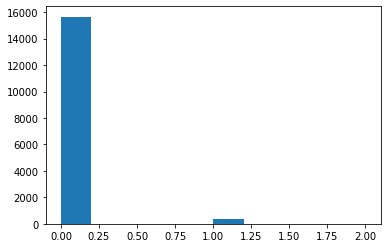

In [25]:
plt.hist(t)
plt.show()

In [26]:
t1 = [e for e in t if e > 0]

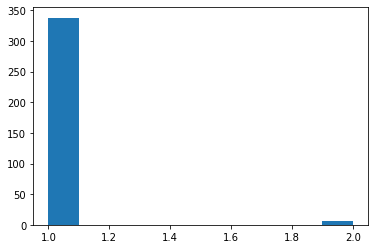

In [27]:
plt.hist(t1)
plt.show()